In [1]:
import os
import PIL
import json
import numpy as np
from tqdm import tqdm
from random import shuffle
from PIL import ImageEnhance, ImageFont, ImageDraw
from math import log, exp

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.python.keras.utils.data_utils import Sequence
from multiprocessing import Pool
from efficientnet.tfkeras import EfficientNetB7

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

tf.keras.backend.clear_session()  # For easy reset of notebook state.

cat_list = ['Apple','Dog','Guitar']

input_shape = (224,224,3)
wt_decay = 5e-4

base_path = 'D:/Object Detection/OID'
data_folder = os.path.join( base_path, 'Dataset' )
train_imgs_folder = os.path.join( data_folder, 'train' )
train_annotations = os.path.join( data_folder, 'cocoannotations','trainannotations.json' )
val_imgs_folder = os.path.join( data_folder, 'val' )
val_annotations = os.path.join( data_folder, 'cocoannotations','valannotations.json' )

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7760815685471947819
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12035170557798944427
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5066607840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11344516816211739016
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3033471511685680819
physical_device_desc: "device: XLA_GPU device"
]


In [2]:
def iou(bb1, bb2):
    x1,y1,w1,h1 = bb1
    xmin1 = x1 - w1/2
    xmax1 = x1 + w1/2
    ymin1 = y1 - h1/2
    ymax1 = y1 + h1/2

    x2,y2,w2,h2 = bb2
    xmin2 = x2 - w2/2
    xmax2 = x2 + w2/2
    ymin2 = y2 - h2/2
    ymax2 = y2 + h2/2

    area1 = w1*h1
    area2 = w2*h2

    # Compute the boundary of the intersection
    xmin_int = max( xmin1, xmin2 )
    xmax_int = min( xmax1, xmax2 )
    ymin_int = max( ymin1, ymin2 )
    ymax_int = min( ymax1, ymax2 )
    intersection = max(xmax_int - xmin_int, 0) * max( ymax_int - ymin_int, 0 )

    # Remove the double counted region
    union = area1+area2-intersection

    return intersection / union

In [3]:
def custom_loss(ytrue, ypred):
    obj_loss_weight = 1.0
    cat_loss_weight = 1.0
    loc_loss_weight = 1.0

    end_cat = len(cat_list) + 1

    ytrue_obj, ypred_obj = ytrue[:,:,:,:1], ypred[:,:,:,:1]   # 1st layer
    objectness_loss = tf.keras.losses.BinaryCrossentropy()( ytrue_obj, ypred_obj ) 
    ypred = tf.where( ytrue[:,:,:,:1] != 0, ypred, 0 )   # if 1st layer is not 0, take value of ypred, else 0
    
    ytrue_cat, ypred_cat = ytrue[:,:,:,1:end_cat], ypred[:,:,:,1:end_cat]  #2nd layer ~ x classes layer
    categorical_loss = tf.keras.losses.CategoricalCrossentropy() ( ytrue_cat, ypred_cat )

    ytrue_loc, ypred_loc = ytrue[:,:,:,end_cat:], ypred[:,:,:,end_cat:]    # after classes layer
    localisation_loss = tf.keras.losses.Huber() ( ytrue_loc, ypred_loc )

    return obj_loss_weight*objectness_loss + cat_loss_weight*categorical_loss + loc_loss_weight*localisation_loss

In [4]:
def model(backbone_model, input_shape, wt_decay):
    inputs = tf.keras.Input(shape=input_shape)
    backbone_output = backbone_model(inputs) #7

    
    x = layers.Conv2D(512, 1, padding='same', kernel_regularizer=l2(wt_decay))(backbone_output) #7
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.01)(x)

    x = layers.Conv2D(256, 1, padding='same', kernel_regularizer=l2(wt_decay))(x) #7
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.01)(x)
    x = layers.Conv2DTranspose(512, 5, strides=(2, 2), padding='same')(x) #14
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.01)(x)

    #x = layers.Concatenate()([x,intermediate_output])

    x = layers.Conv2D(256, 1, padding='same', kernel_regularizer=l2(wt_decay))(x) #14
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.01)(x)
    x = layers.Conv2D(512, 3, padding='same', kernel_regularizer=l2(wt_decay))(x) #14
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.01)(x)
    x = layers.Conv2D(256, 1, padding='same', kernel_regularizer=l2(wt_decay))(x) #14
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.01)(x)
    x = layers.Conv2D(512, 3, padding='same', kernel_regularizer=l2(wt_decay))(x) #14
    x = layers.BatchNormalization()(x)
    tens_14x14 = layers.LeakyReLU(0.01)(x)



    # For each dimension, construct a predictions tensor. Accumulate them into a dictionary for keras to understand multiple labels.
    objectness_preds = layers.Conv2D(1, 1, kernel_regularizer=l2(wt_decay), name = 'Objectness')( tens_14x14 )
    class_preds = layers.Conv2D(len(cat_list), 1, kernel_regularizer=l2(wt_decay), name = 'Classes')( tens_14x14 )
    bbox_preds = layers.Conv2D(4, 1, kernel_regularizer=l2(wt_decay), name = 'BoxCoordinates')( tens_14x14 )
    predictions = layers.Concatenate()( [objectness_preds, class_preds, bbox_preds] )
    
    predictions = layers.Reshape( (14,14, 5+len(cat_list)))(predictions)

    model = tf.keras.Model(inputs, predictions)
    
    for layer in backbone_model.layers:
        layer.trainable = False
    
    model.compile( optimizer=tf.keras.optimizers.Adam(1e-4),
                 loss=custom_loss )
    return model

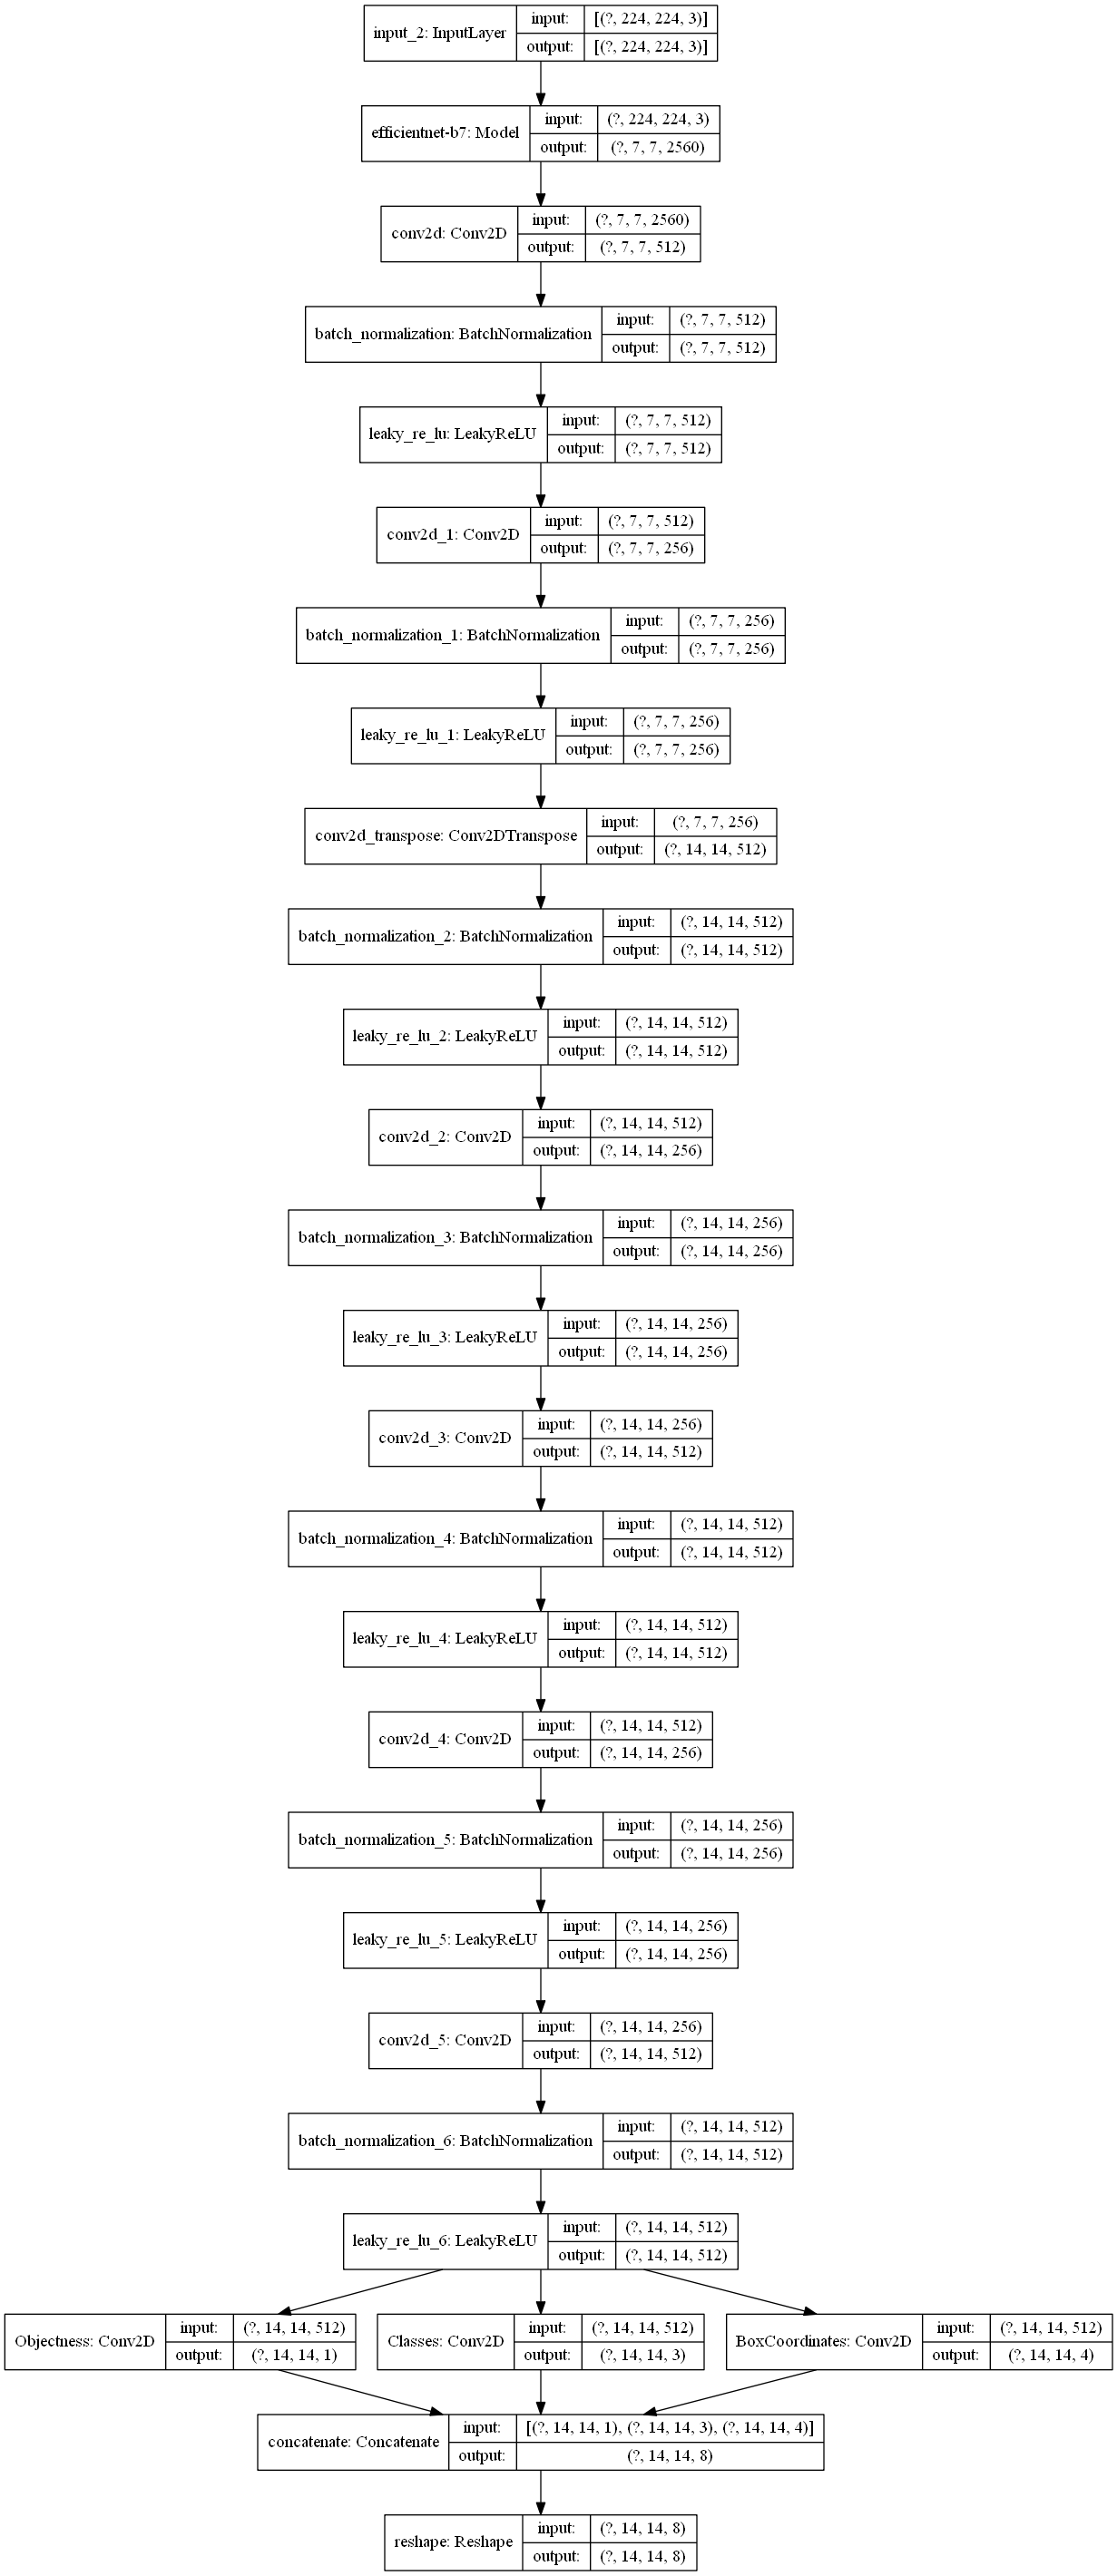

In [5]:
backbone_model = EfficientNetB7(include_top=False, input_shape=input_shape)
model = model(backbone_model, input_shape=input_shape, wt_decay=wt_decay)

    
from tensorflow.keras.utils import plot_model
plot_model(model,to_file=r'D:\Object Detection\OID\model.png', show_shapes=True, show_layer_names=True)

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
efficientnet-b7 (Model)         (None, 7, 7, 2560)   64097680    input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 7, 7, 512)    1311232     efficientnet-b7[1][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 7, 7, 512)    2048        conv2d[0][0]                     
______________________________________________________________________________________________

## Prepare data for input

In [7]:
def encode_label(label_arr, iou_fn, cat_list, iou_threshold=0.5):
    num_entries = 5 + len(cat_list) # objectness, ... len(cat_list) ..., dx, dy, dw, dh
    label_tensor = np.zeros( (14,14, num_entries ) )
    zeros = [0] * len(cat_list)
    for label in label_arr:
        gtclass, gtx, gty, gtw, gth = label
        gtclass = int(gtclass)
        gt_bbox = [gtx, gty, gtw, gth]
        

        iou_scores = []
        
        kx,ky = 14,14
        gapx = 1.0 / kx    #distance per x-tile
        gapy = 1.0 / ky
        '''
        There are kx x ky tiles. 
        For now, all have the same w,h of gapx,gapy. 
        For the (i,j)-th tile, x = 0.5*gapx + i*gapx = (0.5+i)*gapx | y = (0.5+j)*gapy
        '''
        for i in range(kx):
            for j in range(ky):
                x = (0.5+i)*gapx   #x coordinate of tile center
                y = (0.5+j)*gapy   #y coordinate of tile center
                w = gapx
                h = gapy
                candidate_bbox = [x,y,w,h]

                # SSD formulation
                dx = (gtx - x) / w 
                dy = (gty - y) / h
                dw = log( gtw / w )
                dh = log( gth / h )

                IoU = iou_fn( candidate_bbox, gt_bbox )
                iou_scores.append( (IoU, i, j, dx, dy, dw, dh) )

        iou_scores.sort( key=lambda x: x[0], reverse=True )
  
        top_count = max( round(len(iou_scores) * 0.25), 1)
        # Remove all the grid cells that do not overlap with ground truth at all
        iou_scores = [iou_score for iou_score in iou_scores if iou_score[0] > 0]      #if iou = 0, no overlap of boxes, hence exclude
        iou_scores = iou_scores[:top_count] + [iou_score for iou_score in iou_scores[top_count:] if iou_score[0] >= iou_threshold]
        # top 25% + iou score if iou>= threshold
        # Always take the top IoU entry
        for iou_score in iou_scores:
        # The top IoU score is always included
            IoU, i, j, dx, dy, dw, dh = iou_score
            payload = [IoU,*zeros, dx,dy,dw,dh]
            payload[gtclass] = 1
            label_tensor[i,j,:] = payload
    return label_tensor

In [8]:
class DataSequence(Sequence):
    def __init__(self, img_folder, json_annotation_file, batch_size, input_size, label_encoder,testmode=False):
        
        self._prepare_data(img_folder, json_annotation_file)
        self.batch_size = batch_size
        self.input_wh = (*input_size[:2][::-1],input_size[2])   # literally the just input dimensions
        self.testmode = testmode
        self.label_encoder = label_encoder
        
    def _prepare_data(self, img_folder, json_annotation_file):
        imgs_dict = {im:im for im in os.listdir(img_folder) if im.endswith('.jpg')} #im.split('.')[0] depending on naming convention
        data_dict = {}
        with open(json_annotation_file, 'r') as f:
            annotations_dict = json.load(f)
        annotations_list = annotations_dict['annotations']
        for annotation in annotations_list:
            img_id = str(annotation['image_id'])
            c = annotation['category_id']        # TODO: make sure that category ids start from 1, not 0
            boxleft,boxtop,boxwidth,boxheight = annotation['bbox']
            if img_id in imgs_dict:
                img_path = os.path.join(img_folder, imgs_dict[img_id])
                imwidth,imheight = PIL.Image.open(img_path).size
                if img_id not in data_dict:
                    data_dict[img_id] = []
                box_cenx = boxleft + boxwidth/2.
                box_ceny = boxtop + boxheight/2.
                x,y,w,h = box_cenx/imwidth, box_ceny/imheight, boxwidth/imwidth, boxheight/imheight

                data_dict[img_id].append( [c,x,y,w,h] )
        self.x, self.y, self.ids = [], [], []
        #self.x = file path of image
        #self.y = [c,x,y,w,h]
        #self.ids = image name
        for img_id, labels in data_dict.items():
            self.x.append( os.path.join(img_folder, imgs_dict[img_id]) )
            self.y.append( np.array(labels) )
            self.ids.append( img_id )

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))
    
    def preprocess_fn(self, x):
        return x * 1./255.    
    
    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        x_acc, y_acc = [], []
        original_img_dims = []
        with Pool(self.batch_size) as p:
          # Read in the PIL objects from filepaths
            batch_x = p.map(load_img, batch_x)
        
        for x,y in zip( batch_x, batch_y ):
            W,H = x.size
            original_img_dims.append( (W,H) )

            x = x.resize( self.input_wh[:2] )
            x_aug, y_aug = np.array(x), y        # augmentation techniques not done yet
            x_acc.append( np.array(x_aug) )
            y_tensor = self.label_encoder( y_aug )
            y_acc.append( y_tensor )
            
        return self.preprocess_fn( np.array( x_acc ) ), np.array( y_acc )


In [10]:
ES1 = EarlyStopping(monitor='val_loss', patience=25)
MC1 = ModelCheckpoint(
    filepath=(os.path.join(base_path, 'Extra layers after EfficientNetB7 warmed.h5')),
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=True,
    verbose=1)
LR1 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr = 1e-8, mode='auto',verbose=1)

In [35]:
print(train_sequence[46][0].shape)
print(train_sequence[0][0].shape)

(28, 224, 224, 3)
(32, 224, 224, 3)


In [12]:
bs=32
n_epochs_warmup = 100
n_epochs_after = 100
label_encoder = lambda y: encode_label(y, iou, cat_list,iou_threshold=0.5)
print('Creating training sequence...')
train_sequence = DataSequence(train_imgs_folder, train_annotations, bs, input_shape, label_encoder)

print('Creating validation sequence...')
val_sequence = DataSequence(val_imgs_folder, val_annotations, bs, input_shape, label_encoder)




print('Warming up the model...')
model.fit(x=train_sequence, 
          epochs=n_epochs_warmup, 
          validation_data=val_sequence, 
          callbacks=[MC1, ES1, LR1])



Creating training sequence...
Creating validation sequence...
Warming up the model...
Epoch 1/100
47/47 [==============================] - ETA: 0s - loss: 3.9988
Epoch 00001: val_loss did not improve from 2.42841
47/47 [==============================] - 181s 4s/step - loss: 3.9988 - val_loss: 2.5403 - lr: 1.0000e-05
Epoch 2/100
47/47 [==============================] - ETA: 0s - loss: 3.8585
Epoch 00002: val_loss did not improve from 2.42841
47/47 [==============================] - 187s 4s/step - loss: 3.8585 - val_loss: 2.4938 - lr: 1.0000e-05
Epoch 3/100
47/47 [==============================] - ETA: 0s - loss: 3.5703
Epoch 00003: val_loss did not improve from 2.42841
47/47 [==============================] - 190s 4s/step - loss: 3.5703 - val_loss: 2.5454 - lr: 1.0000e-05
Epoch 4/100
47/47 [==============================] - ETA: 0s - loss: 3.3941
Epoch 00004: val_loss did not improve from 2.42841
47/47 [==============================] - 187s 4s/step - loss: 3.3941 - val_loss: 2.6431 - l

In [13]:
# To fix multiple, we introduce non-maximum suppression, or NMS for short
def nms(detections, iou_thresh):
    dets_by_class = {}
    final_result = []
    for det in detections:
        cls = det[1]
        if cls not in dets_by_class:
            dets_by_class[cls] = []
        dets_by_class[cls].append( det )
    for _, dets in dets_by_class.items():
        candidates = list(dets)
        candidates.sort( key=lambda x:x[0], reverse=True )
        while len(candidates) > 0:
            candidate = candidates.pop(0)
            _,_,cx,cy,cw,ch = candidate
            copy = list(candidates)
            for other in candidates:
            # Compute the IoU. If it exceeds thresh, we remove it
                _,_,ox,oy,ow,oh = other
                if iou( (cx,cy,cw,ch), (ox,oy,ow,oh) ) > iou_thresh:
                    copy.remove(other)
            candidates = list(copy)
            final_result.append(candidate)
    return final_result

In [14]:
load_model_path = os.path.join( base_path, 'Extra layers after EfficientNetB7 warmed.h5' )
model = tf.keras.models.load_model(load_model_path, custom_objects={'custom_loss':custom_loss})
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
efficientnet-b7 (Model)         (None, 7, 7, 2560)   64097680    input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 7, 7, 512)    1311232     efficientnet-b7[1][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 7, 7, 512)    2048        conv2d[0][0]                     
______________________________________________________________________________________________

In [38]:
label_encoder = lambda y: encode_label(y, iou, cat_list,iou_threshold=0.5)
preproc_fn = lambda x: x / 255.

test_sequence = DataSequence(val_imgs_folder, val_annotations, 1, input_shape, label_encoder, testmode=True)

In [61]:
test_sequence[0][0].shape

(1, 224, 224, 3)

In [85]:
def decode_tensor(label_arr, det_threshold, top=None):
  kx, ky = label_arr.shape[:2]
  gapx = 1. / kx
  gapy = 1. / ky
  # Find the locations of the label_arr where the objectness-score (detection confidence) exceeds the threshold. 
  # These are the detections we will visualize.
  # The lower the threshold, the more false positives we are likely to get.
  eyes, jays = np.where( label_arr[:,:,0] > det_threshold ) #i's and j's are the coordinates of the tensor.
  labels = []
  for i,j in zip(eyes,jays):
    cx = (0.5+i)*gapx
    cy = (0.5+j)*gapy
    w = gapx
    h = gapy

    det_score, p_apple, p_dog, p_guitar, dx, dy, dw, dh = label_arr[i,j]

    # Reverse the targets based on the SSD formulation, to obtain proper x,y,w,h information
    predx = (dx * w) + cx
    predy = (dy * h) + cy
    predw = w * exp( dw )
    predh = h * exp( dh )
    category_id = (np.argmax([p_apple, p_dog, p_guitar]))+1
    labels.append( (det_score, category_id, predx, predy, predw, predh) )
  labels.sort( key=lambda x:x[0], reverse=True )
  labels = labels[:3]
  return labels

In [80]:
testimg = test_sequence[0][0]
model_pred = model(testimg)[0]
preds = decode_tensor(model_pred,det_threshold=0.1)
preds = nms(preds, iou_thresh=0.8)
preds

[(<tf.Tensor: shape=(), dtype=float32, numpy=0.17239273>,
  2,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.6078472>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.68526536>,
  0.06501616081379726,
  0.07301143678531857),
 (<tf.Tensor: shape=(), dtype=float32, numpy=0.12022621>,
  2,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.88774973>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.04395819>,
  0.07174596467048927,
  0.06681557485079306),
 (<tf.Tensor: shape=(), dtype=float32, numpy=0.11289421>,
  2,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.4711786>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.618121>,
  0.06242495540714349,
  0.06932896981816583),
 (<tf.Tensor: shape=(), dtype=float32, numpy=0.13544503>,
  1,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.7495449>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.6862881>,
  0.06449974799690927,
  0.07238671084561839),
 (<tf.Tensor: shape=(), dtype=float32, numpy=0.11853483>,
  1,
  <tf.Tensor: shape=(), dtype=float32, 

In [86]:
testimg = load_img(os.path.join(val_imgs_folder,'8ce6d8afb2779d20.jpg'),target_size = (224, 224))
testarray = img_to_array(testimg)
testarray = testarray/255.
testarray = np.expand_dims(testarray,0)
W,H = testimg.size

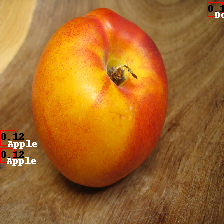

In [87]:
model_pred = model(testarray)[0]
preds = decode_tensor(model_pred,det_threshold=0.1)
preds = nms(preds, iou_thresh=0.8)
draw_img = testimg.copy()
draw = ImageDraw.Draw(draw_img)
for i, pred in enumerate(preds):
    conf,cls,x,y,w,h = pred
    bb_x = int(x * W)
    bb_y = int(y * H)
    bb_w = int(w * W)
    bb_h = int(h * H)
    left = int(bb_x - bb_w / 2)
    top = int(bb_y - bb_h / 2)
    right = int(bb_x + bb_w / 2)
    bot = int(bb_y + bb_h / 2)
    cls_str = cat_list[cls-1]

    draw.rectangle(((left, top), (right, bot)), outline='red')
    draw.text((bb_x, bb_y), cls_str, fill='white')
    draw.text( ( int(left + bb_w*.1), int(top + bb_h*.1) ), '{:.2f}'.format(conf), fill='black' )

display(draw_img)

In [ ]:
tensor = tf.constant([
  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
   [5, 6, 7, 8, 9, 10,11,12,13,14],
   [15,16,17,18,19,20,21,22,23,24],
   [25,26,27,28,29,30,31,32,33,34]],

  [[35,36,37,38,39,40,41,42,43,44],
   [45,46,47,48,49,50,51,52,53,54],
   [55,56,57,58,59,60,61,62,63,64],
   [65,66,67,68,69,70,71,72,73,74]],
    
  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
   [5, 6, 7, 8, 9, 10,11,12,13,14],
   [15,16,17,18,19,20,21,22,23,24],
   [25,26,27,28,29,30,31,32,33,34]],

  [[35,36,37,38,39,40,41,42,43,44],
   [45,46,47,48,49,50,51,52,53,54],
   [55,56,57,58,59,60,61,62,63,64],
   [65,66,67,68,69,70,71,72,73,74]]])
    
   #[75,76,77,78,79,80,81,82,83,84]]])

print(tensor)


In [ ]:
print(tensor[0][0][0])
print(tensor[0][1][0])
print(tensor[0][2][0])
print(tensor[1][0][0])
print(tensor[:,:,:1])